In [53]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
plt.rcParams['axes.grid'] = True
plt.rcParams['image.aspect'] = 0.8

import numpy as np
import casadi as ca
import time
from helper_fns import *

def timed_exec(fn, *args):
    start = time.time()
    res = fn(*args)
    elapsed = time.time() - start
    return elapsed, *res

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
## MPC only, i.e. without iCEM warmstart
mpc, params = spawn_mpc()

params['belief_free'] = 1.0
params['belief_point'] = 0.0

t_mpc_free_cold, cost, res = timed_exec(mpc.solve, params)
t_mpc_free_warm, cost_free, res = timed_exec(mpc.solve, params)

params['belief_free'] = 0.0
params['belief_point'] = 1.0

t_mpc_point, cost_point, res_point = timed_exec(mpc.solve, params)

print(f"Free space cold {t_mpc_free_cold}, Free space warm {t_mpc_free_warm}, Point: {t_mpc_point}")
print(f"Free space: {t_mpc_free_warm}, {cost_free} \n     Point: {t_mpc_point}, {cost_point}")
res['imp_stiff'] = params['imp_stiff']
traj_mpc = mpc.robots['point'].get_ext_state(res_point)
#print(traj_mpc['contact_1/F'][0,:])
#print(traj_mpc['F_imp'])
#print(traj_mpc['imp_rest'])

Adding contact setpoint cost for contact_1/F
Free space cold 0.10059022903442383, Free space warm 0.012032747268676758, Point: 0.050028085708618164
Free space: 0.012032747268676758, 1.06913 
     Point: 0.050028085708618164, 1.15584


In [71]:
# iCEM-only result
mpc, params = spawn_mpc()

params['belief_free'] = 1.0
params['belief_point'] = 0.0

time_cem_free, cost_free, res = timed_exec(mpc.icem_warmstart, params)
#print(res['imp_rest'])

cost, res = mpc.solve(params) # with an initialization

params['belief_free'] = 0.0
params['belief_point'] = 1.0
time_cem_point, cost_point, res = timed_exec(mpc.icem_warmstart, params)
print(f"Free space: {time_cem_free}, {cost_free} \n     Point: {time_cem_point}, {cost_point}")

traj_cem = mpc.robots['point'].get_ext_state(res)
#print(traj_cem['imp_rest'])

Adding contact setpoint cost for contact_1/F
Free space: 0.1842179298400879, 1.34474 
     Point: 0.1630232334136963, 3.51261


In [94]:
iters = [0, 1, 2, 3, 4, 5, 10, 15]
#iters = [0, 1, 2]
N = 5
mpc, params = spawn_mpc()
mpc.solve(params)
iter_times_mean = []
iter_times_std = []
iter_cost_mean = []
iter_cost_std = []
q0 = params['q']
dq0 = params['dq']
for n_iter in iters:
    times = []
    costs = []
    for _ in range(N):
        mpc.reset_warmstart()
        params['belief_free'] = 1.0
        params['belief_point'] = 0.0 
        mpc.solve(params)
        
        params['belief_free'] = 0.0
        params['belief_point'] = 1.0
        params['q'] = q0+0.05*np.random.randn(7) # perturb initial state
        params['dq'] = dq0+0.1*np.random.randn(7) # perturb initial state
        tic = time.perf_counter()
        if n_iter > 0: mpc.icem_warmstart(params, num_iter=n_iter)
        cost, _ = mpc.solve(params)
        times.append(time.perf_counter()-tic)
        costs.append(np.squeeze(cost.full()))
    iter_times_mean.append(np.mean(times))
    iter_times_std.append(np.std(times))
    iter_cost_mean.append(np.mean(costs))
    iter_cost_std.append(np.std(costs))

Adding contact setpoint cost for contact_1/F


Text(0, 0.5, 'Solve time')

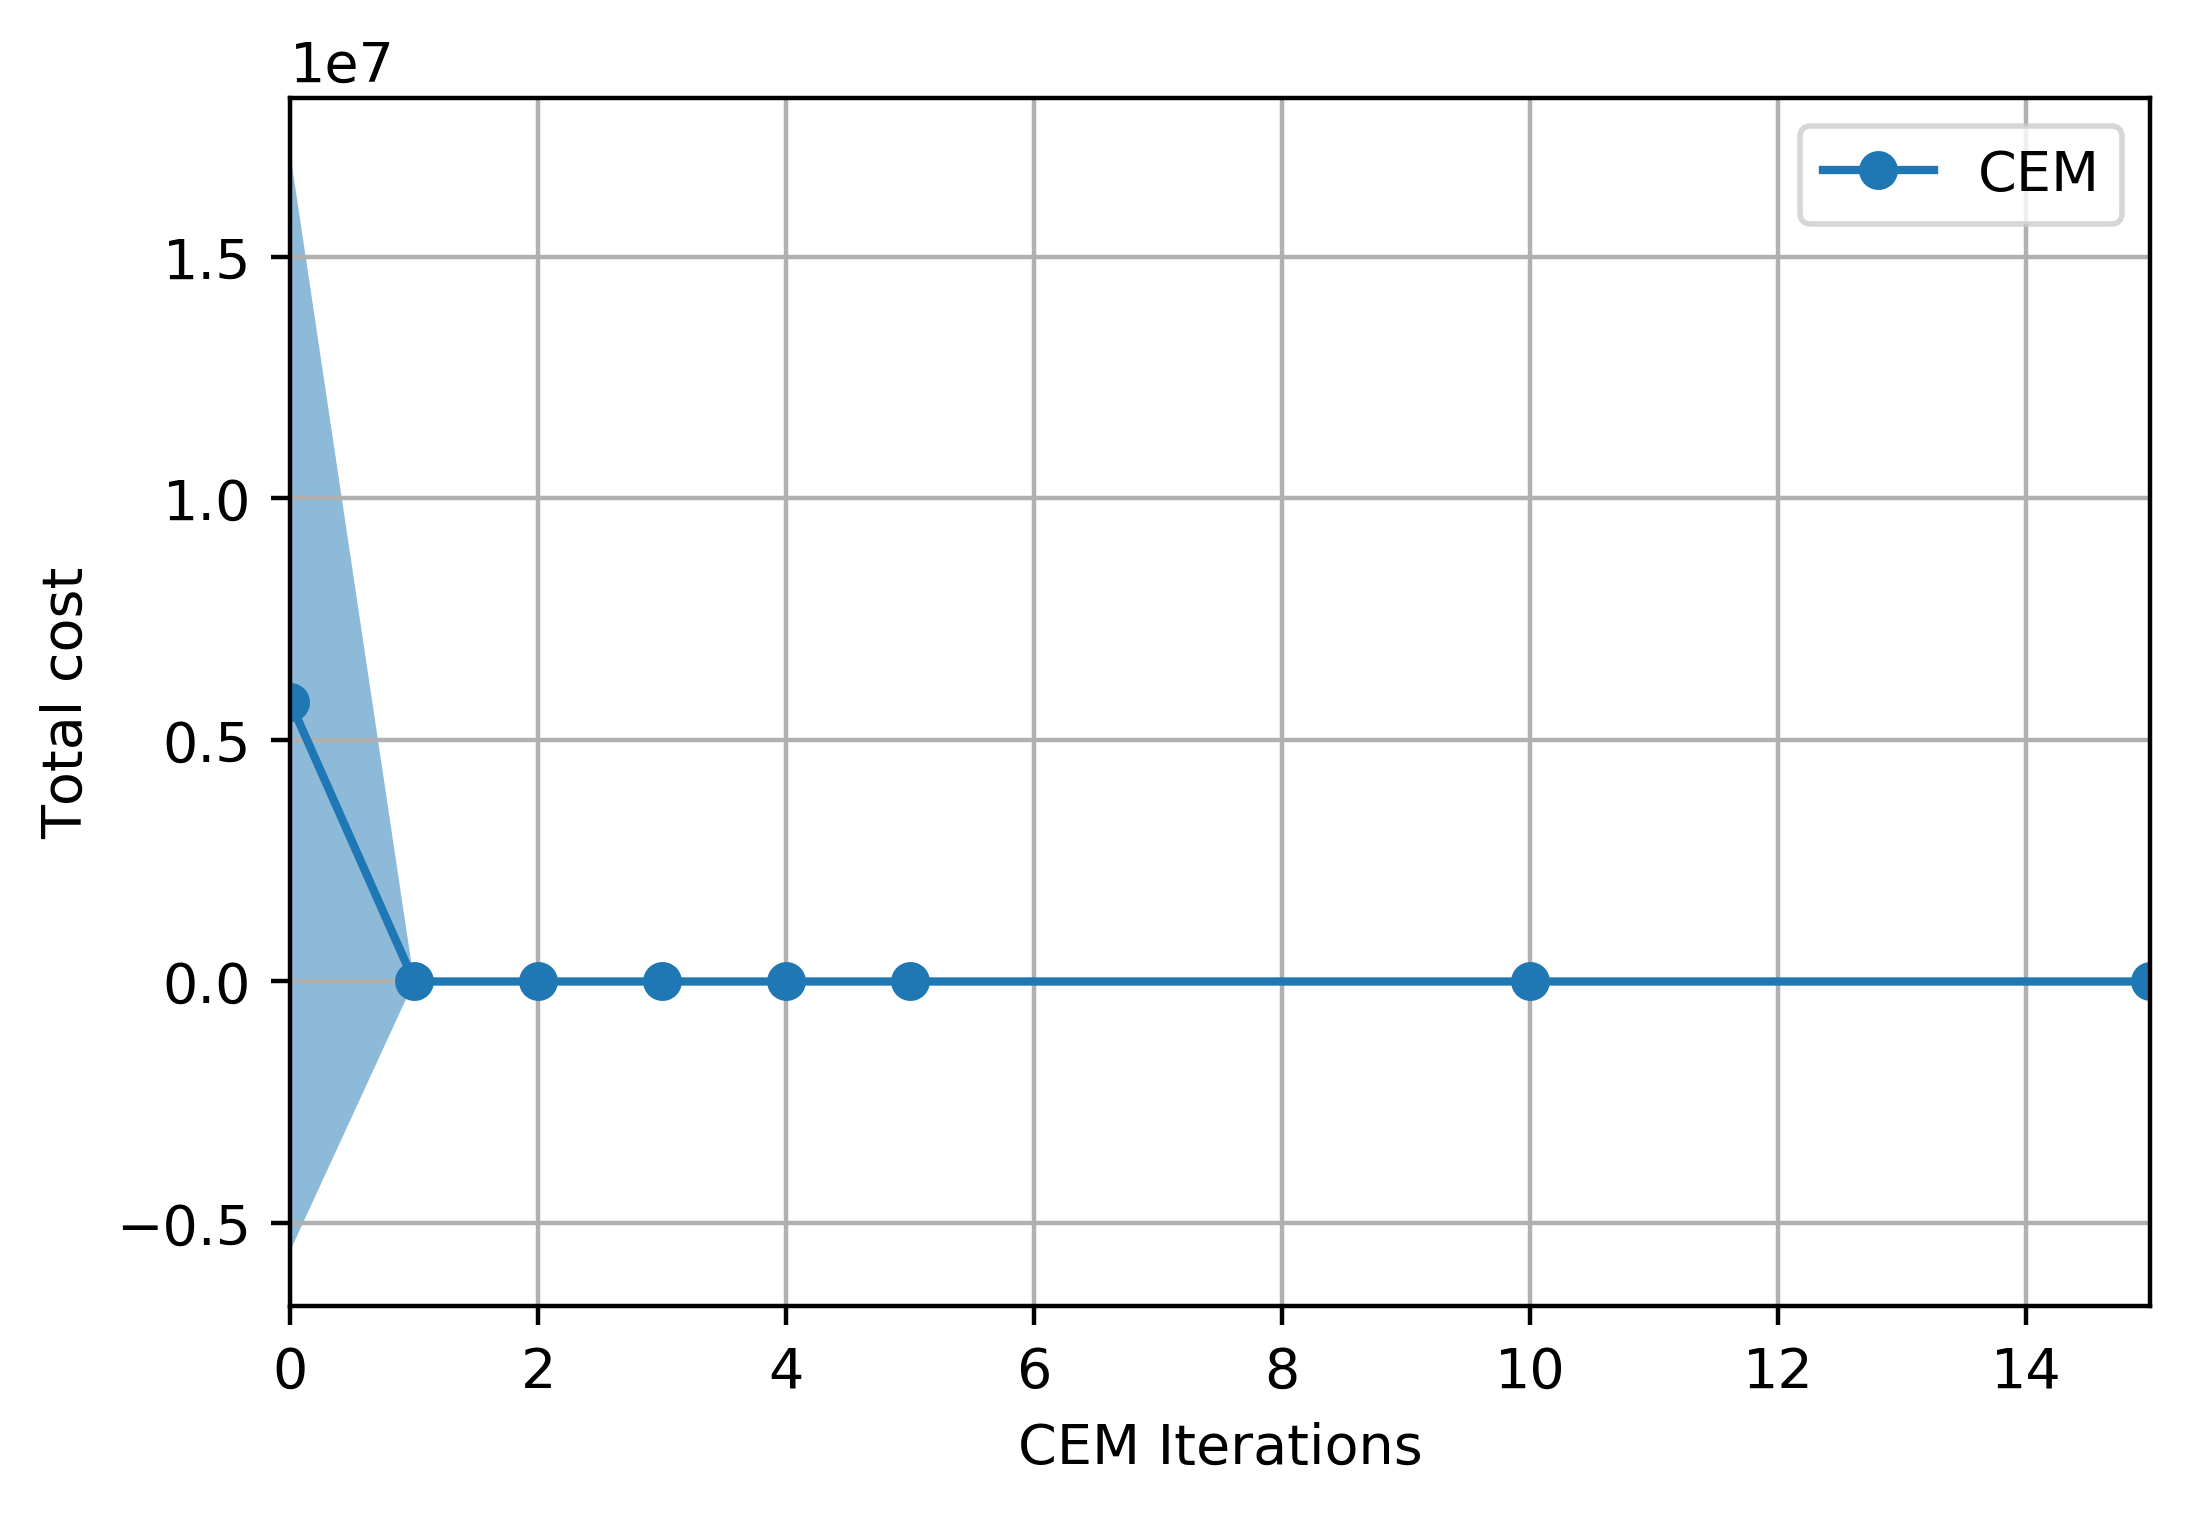

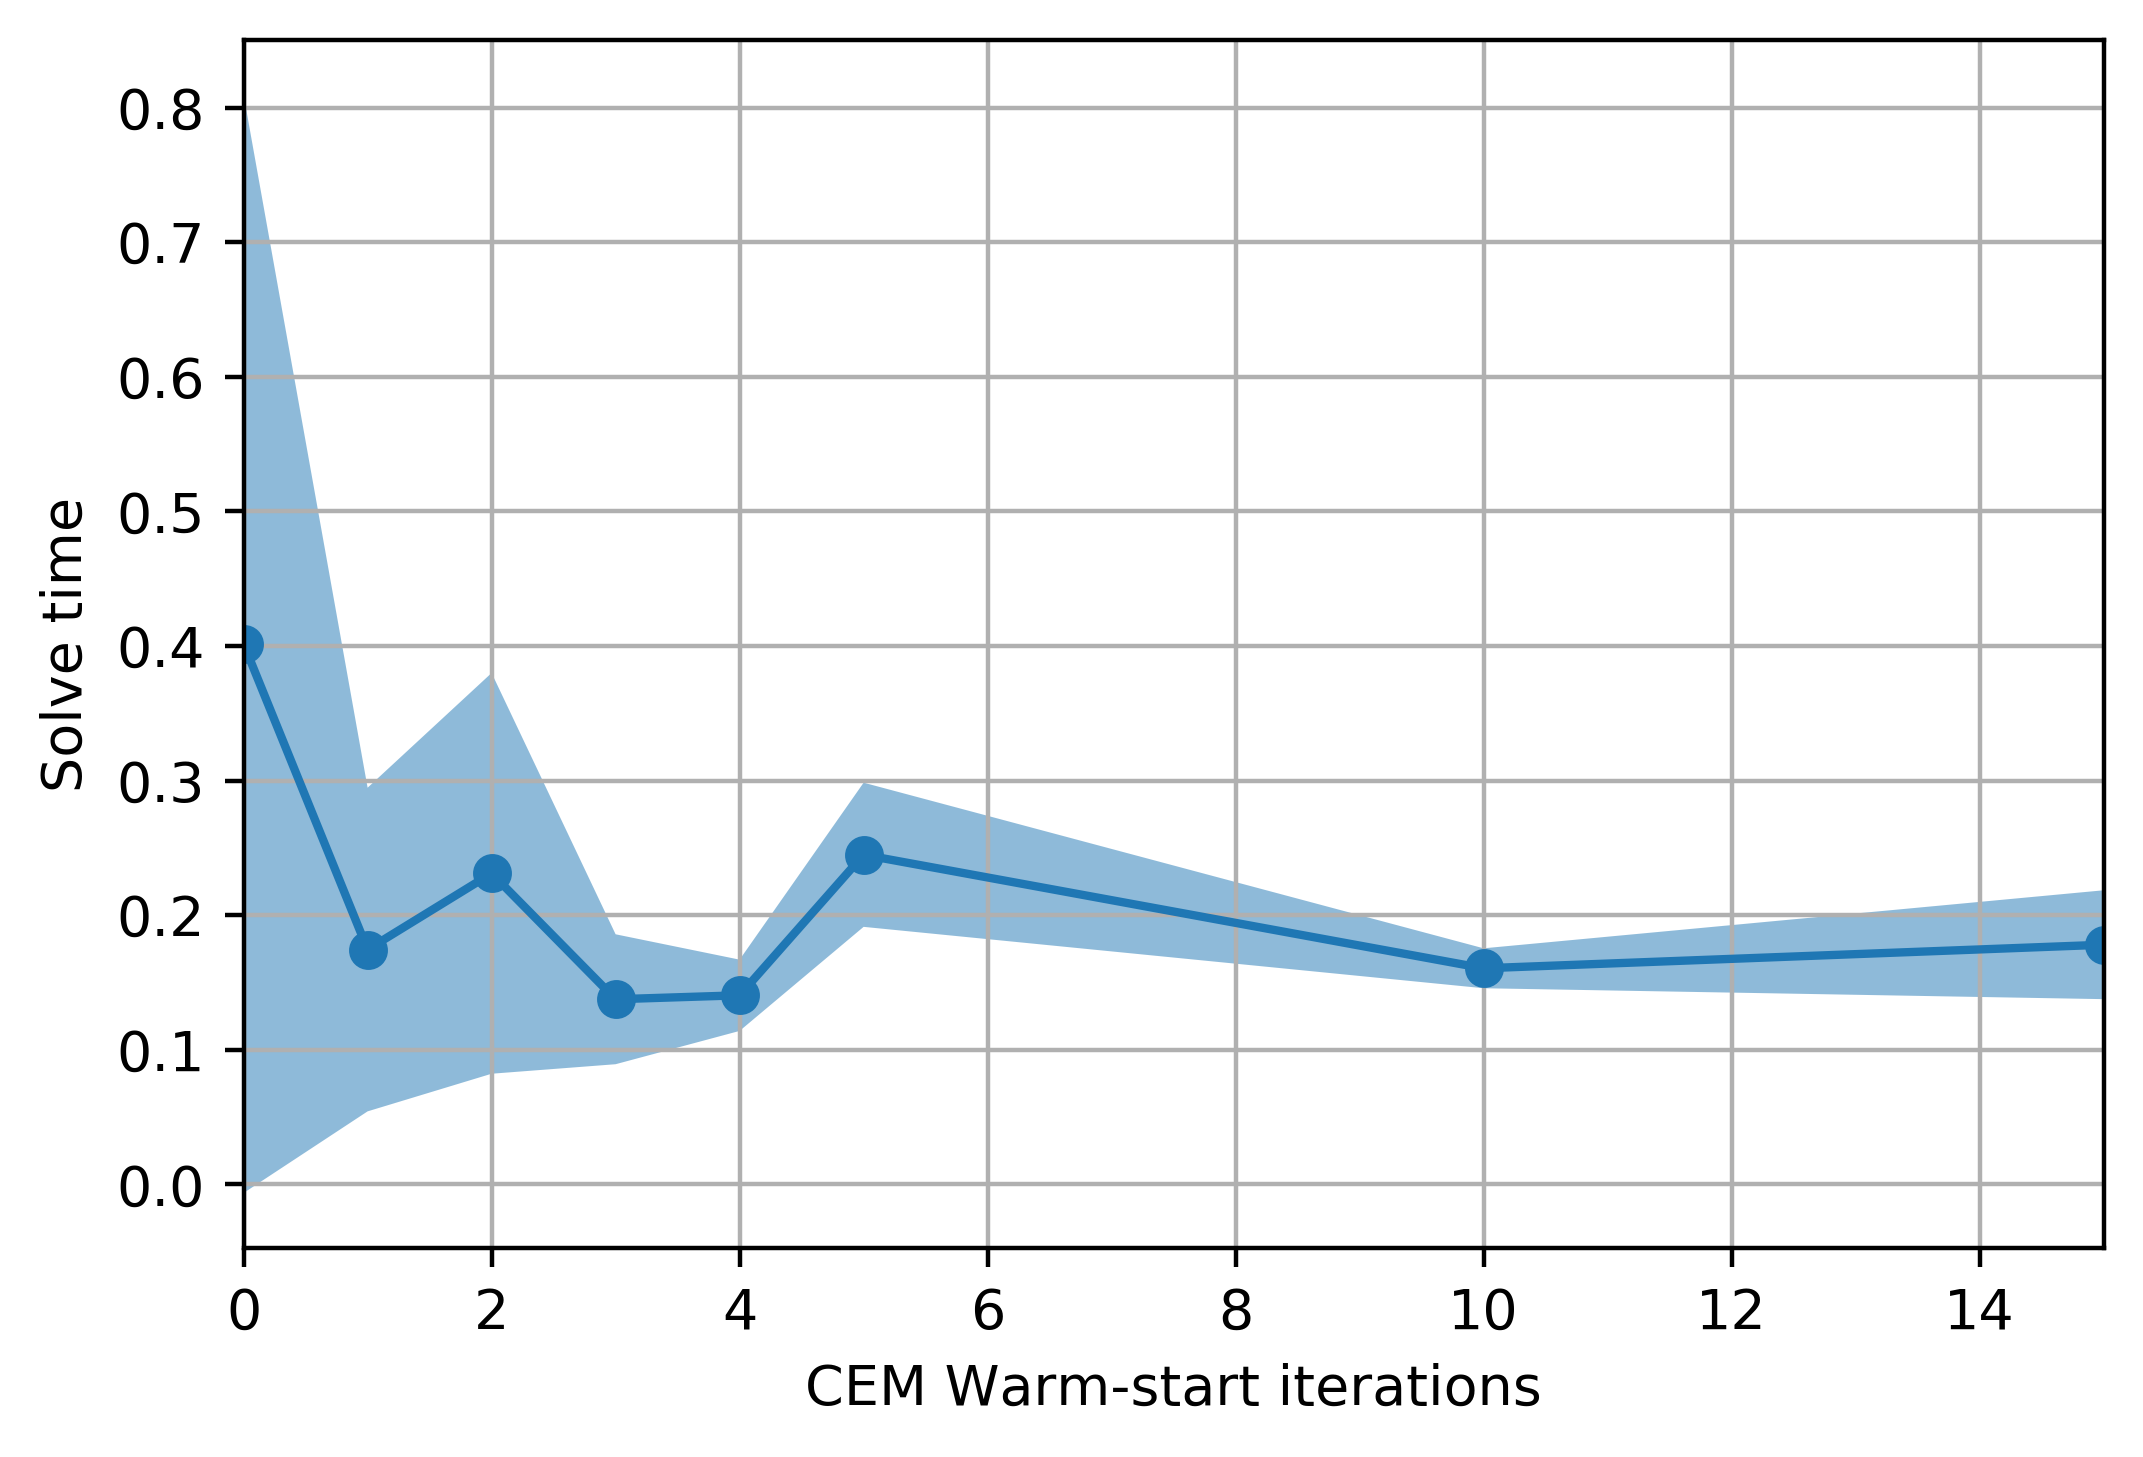

In [95]:
plt.plot(iters, iter_cost_mean, label='CEM', marker='o')
mu = np.array(iter_cost_mean)
sig = np.array(iter_cost_std)
plt.fill_between(iters, mu-sig, mu+sig, alpha=0.5)

plt.legend()
plt.xlim(0,iters[-1])
plt.xlabel('CEM Iterations')
plt.ylabel('Total cost')

plt.figure()
plt.plot(iters, iter_times_mean, marker='o')
mu = np.array(iter_times_mean)
sig = np.array(iter_times_std)
plt.fill_between(iters, mu-sig, mu+sig, alpha=0.5)
plt.xlim(0,iters[-1])
plt.xlabel('CEM Warm-start iterations')
plt.ylabel('Solve time')
#plt.savefig('cem_warmstart_num_iter.pdf')

In [79]:
# Increasing stiffness, seems like at K > 2.5e3, we get relative infeasibility for the MPC and the cem warmstart helps a lot




In [193]:
# Increasing planning horizon


In [88]:
# Switched model, also does well 
from helper_fns import *
mpc, params = spawn_mpc(switched=True, print_level=0)
params['belief_free'] = 1.0
mpc.solve(params)
iters = [0, 1, 2, 3, 4, 5, 10, 15, 20]
N = 15
q0 = params['q']
dq0 = params['dq']
mpc.solve(params)
iter_times_mean = []
iter_times_std = []
iter_cost_mean = []
iter_cost_std = []
for n_iter in iters:
    times = []
    costs = []
    for _ in range(N):
        mpc.reset_warmstart()
        params['belief_free'] = 1.0
        params['belief_point'] = 0.0 
        params['q'] = q0+0.005*np.random.randn(7) # perturb initial state
        params['dq'] = dq0+0.01*np.random.randn(7) # perturb initial state
        tic = time.perf_counter()
        if n_iter > 0: mpc.icem_warmstart(params, num_iter=n_iter)
        cost, res = mpc.solve(params)
        times.append(time.perf_counter()-tic)
        costs.append(np.squeeze(cost.full()))
    iter_times_mean.append(np.mean(times))
    iter_times_std.append(np.std(times))
    iter_cost_mean.append(np.mean(costs))
    iter_cost_std.append(np.std(costs))


Adding contact setpoint cost for contact_1/F


In [102]:
mpc, params = spawn_mpc(switched=True, print_level=0)
params['belief_free'] = 1.0
cost, res = mpc.solve(params)
traj = mpc.robots['free'].get_ext_state(res)
print(cost)
print(traj['imp_rest'])
print(traj['F_ext'])

Adding contact setpoint cost for contact_1/F


CasADi - 2023-09-07 21:29:02 WARNING("CasADi was not compiled with WITH_THREAD=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:502]


20.465
[[-0.56553435  0.31301846  0.37015334  0.30772008  0.27702104  0.2741198
   0.27665652  0.27750004  0.27684159  0.27566388  0.27436803  0.27303908
   0.27170003  0.27037408  0.2690688   0.26773789  0.26629906  0.26498185
   0.26520586  0.26905327]
 [ 0.00655171  0.13971608  0.14201433  0.12209851  0.11246998  0.10968645
   0.10745301  0.10428898  0.10069046  0.09718475  0.09400041  0.09121107
   0.08884263  0.08690335  0.08538613  0.08426919  0.08353722  0.0832554
   0.08362288  0.08447244]
 [ 1.21939736  0.78882123  0.77133291  0.80177455  0.81530804  0.81651141
   0.81569567  0.8158173   0.81665521  0.81774797  0.81892497  0.82015681
   0.82143989  0.82277007  0.8241469   0.82557677  0.82703698  0.82832478
   0.82883252  0.82796716]]
[[0.         0.         0.         8.72899094 7.10970778 5.41217905
  5.03226052 5.10217628 5.16698335 5.17030297 5.14688904 5.11744383
  5.0867932  5.05497275 5.02144382 4.98803542 4.9672802  4.98527263
  5.01344395 4.73362917]
 [0.         0.   